In [13]:
from datetime import datetime
# from dateutil.relativedelta import relativedelta
import math
from marketdatalib import map_scrip_to_yfin_ticker, get_nifty_index_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from scipy.optimize import minimize

In [14]:
# Number of year of historic data to consider
YEARS_OF_HISTORY = 15

# The risk free return rate. This is often the return on a 10 year government bond.
# At present, the 10 year government bond rate is 6.84%. We are using 7.5% for the sake of simplicity which is the rate of a fixed deposit.
RISK_FREE_RETURN = 0.0735
EXPECTED_MARKET_RETURN = 0.18
ACCEPTABLE_VOLATILITY = 0.15


INDIAN_ETFS = [
    'NIFTY 50',
    'NIFTY 500',
    # , 'NIFTY MIDCAP 150'
    # , 'NIFTY NEXT 50',
    'NIFTY50 VALUE 20'
    ]
INDIAN_ETFS

['NIFTY 50', 'NIFTY 500', 'NIFTY50 VALUE 20']

In [15]:
master_data = pd.DataFrame()

for ind in INDIAN_ETFS:
    index_data = get_nifty_index_data(index_name=ind, number_of_years=YEARS_OF_HISTORY)['Close']
    index_data = pd.Series(index_data)
    index_data = index_data.to_frame(name=ind)
    master_data = master_data.combine_first(index_data)

# For every column in the master_data, add a new columns with name <column_name>_returns containting percentage returns compared to previous day
# It is in the form of (current_price - previous_price) / previous_price (not 1 + r format) and hence additive
for column in master_data:
    master_data[column + '_Return'] = master_data[column].pct_change() + 1

master_data = master_data.dropna()

master_data

,NIFTY 50,NIFTY 500,NIFTY50 VALUE 20,NIFTY 50_Return,NIFTY 500_Return,NIFTY50 VALUE 20_Return
Date,,,,,,
2015-11-10,7783.35,6536.45,3507.00,0.983342,0.984198,0.984532
2015-11-11,7825.00,6585.15,3527.25,1.005351,1.007451,1.005774
2015-11-13,7762.25,6526.60,3502.30,0.991981,0.991109,0.992927
2015-11-16,7806.60,6551.45,3506.90,1.005714,1.003807,1.001313
2015-11-17,7837.55,6580.80,3504.35,1.003965,1.004480,0.999273
...,...,...,...,...,...,...
2025-01-29,23163.10,21245.50,13066.70,1.008967,1.015329,1.010643
2025-01-30,23249.50,21297.50,13065.35,1.003730,1.002448,0.999897
2025-01-31,23508.40,21580.90,13221.80,1.011136,1.013307,1.011974


In [16]:
def expected_return(market_return, risk_free_return, beta, weight = 1):
    """
    Calculate the expected return of a portfolio using the Capital Asset Pricing Model (CAPM).

    Parameters:
    market_return (float): The expected return of the market. Often the return of a broader index like NIFTY 500
    risk_free_return (float): The risk-free rate of return. 10 year government bond rate is often used, or the FD rate.
    beta (float): The beta of the portfolio, representing its sensitivity to market movements.
    weight (float, optional): The weight of the portfolio. Default is 1.

    Returns:
    float: The expected return of the portfolio.
    """
    return risk_free_return + weight * beta * (market_return - risk_free_return)



Let us assume that NIFTY 500 represents the total market for the sake of brevity. It represnts the universe of stocks that are investable in Indian equity market

In [17]:
benchmark_returns = master_data['NIFTY 500_Return']

R_m = benchmark_returns.prod() - 1

Sigma_m = np.std(benchmark_returns - 1)

print(f"Market/Benchmark Return: {R_m}")
print(f"Market/Benchmark Volatility: {Sigma_m}")


Market/Benchmark Return: 2.222596139368215
Market/Benchmark Volatility: 0.010189229688630879


To start with, let us start with a single security portfolio. The portfolio is constructed with NIFTY50 VALUE 20 index.

In [18]:
portfolio_indices = ['NIFTY50 VALUE 20']

In [19]:
from finlib import efficient_frontier, calculate_beta

In [20]:
returns_matrix = pd.DataFrame(index=portfolio_indices, columns=['Return', 'Beta', 'Volatility', 'AbsoluteReturn', 'Sharpe Ratio'])

for index in portfolio_indices:
    index_returns = master_data[index + '_Return'].prod() - 1
    
    # Returns include investment amout + absolute returns
    returns_matrix.loc[index, 'Return'] = index_returns

    returns_matrix.loc[index, 'Beta'] = calculate_beta(master_data[index + '_Return'], benchmark_returns)
    returns_matrix.loc[index, 'Volatility'] = np.std(master_data[index + '_Return'] - 1)
    
    # Absolute return
    returns_matrix.loc[index, 'AbsoluteReturn'] = RISK_FREE_RETURN + returns_matrix.loc[index, 'Beta'] * (R_m - RISK_FREE_RETURN)
    # returns_matrix.loc[index, 'Sharpe Ratio'] = (index_returns - RISK_FREE_RETURN) / returns_matrix.loc[index, 'Volatility']

    print(f"Index: {index}")

returns_matrix

Index: NIFTY50 VALUE 20


,Return,Beta,Volatility,AbsoluteReturn,Sharpe Ratio
NIFTY50 VALUE 20,2.666208,0.841506,0.009921,1.881978,NaN


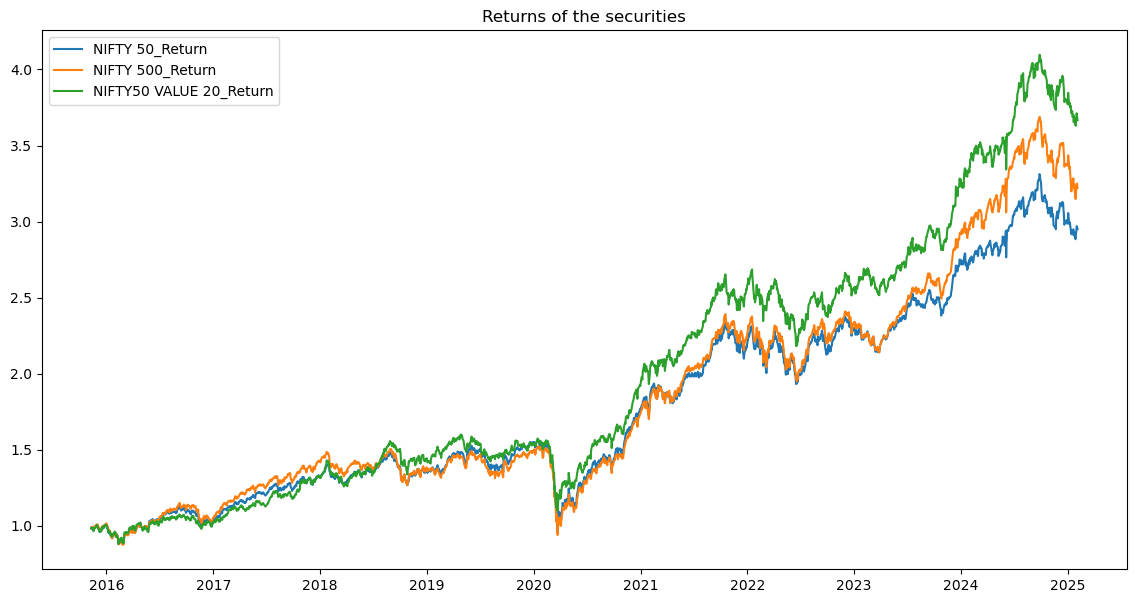

In [21]:
plt.figure(figsize=(14, 7))
for column in master_data:
    if 'Return' in column:
        plt.plot(master_data[column].cumprod(), label=column)
plt.legend()
plt.title('Returns of the securities')
plt.show()

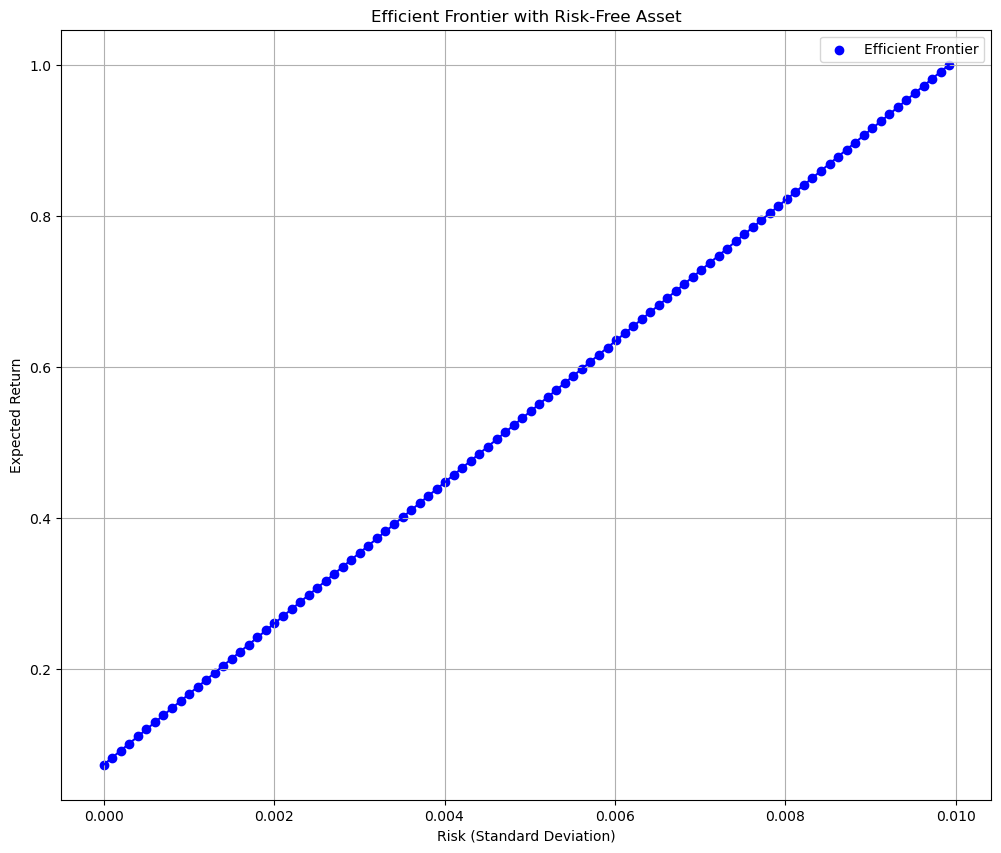

In [22]:
coefficients = list(efficient_frontier(RISK_FREE_RETURN, master_data['NIFTY50 VALUE 20_Return']))

The efficient frontier curve can be a straight line when combining a risk-free asset with a single risky asset. This straight line is known as the Capital Market Line (CML). The CML represents the risk-return trade-off of a portfolio that combines a risk-free asset with a market portfolio.